In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf
import time

import models
import flows

In [2]:
mhnn = models.MHNN(num_tasks=1000, dim=50, name="mhnn")
mhnn.restore()

permutation = list(np.arange(26, 51, 1)) + list(np.arange(0, 26, 1))
nf = flows.MAF(
    dim=51,
    permutation=permutation,
    hidden_layers=[100, 100],
    num_bijectors=10,
    activation=tf.nn.relu,
    name="maf",
)
nf.restore()

#### Figure 1

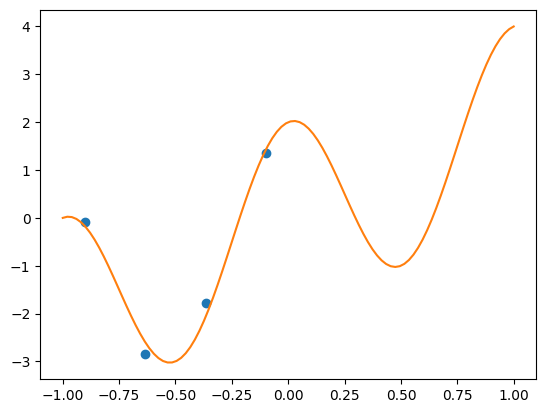

In [3]:
np.random.seed(1234) # for case 1
# np.random.seed(6666) # for case 2
x_test = np.linspace(-1, 1, 100).reshape([-1, 1])

# case 1
x_train = np.linspace(-0.9, -0.1, 4).reshape([-1, 1])
A = 2
w = 2 * np.pi
k = +1

noise = 0.2

y_train = A * np.cos(w * x_train) + 2 * k * x_train
y_train = y_train + noise * np.random.normal(size=y_train.shape)
y_test = A * np.cos(w * x_test) + 2 * k * x_test


plt.plot(x_train, y_train, 'o')
plt.plot(x_test, y_test)

In [4]:
import neuraluq as neuq

Backend is chosen to be the default, tensorflow. You can customize the backend by change it in the 'config.json' file, which can be created or found in your current directory.


In [5]:
class Samplable(neuq.variables._Samplable):
    
    def __init__(self, nf):
        super().__init__()
        self._num_tensors = 1
        self._initial_values = [nf.sample([])]
        self.log_prob_fn = tf.function(nf.log_prob)
    
    def log_prob(self, samples):
        return self.log_prob_fn(samples[0])
    

class Surrogate(neuq.surrogates.Surrogate):

    def __init__(self, meta_model):
        self.meta_model = meta_model
        
    def __call__(self, inputs, var_list):
        # xi = self.flow.std / self.flow.scale * var_list[0] + self.flow.mu
        xi = tf.reshape(var_list[0], [-1, 51])
        return self.meta_model.call(inputs, tf.transpose(xi))

In [6]:
prior = Samplable(nf)
surrogate = Surrogate(mhnn)
process = neuq.process.Process(surrogate=surrogate, prior=prior)

likelihood = neuq.likelihoods.Normal(
    inputs=x_train,
    targets=y_train, 
    sigma=noise, 
    processes=[process],
)

model = neuq.models.Model(
    processes=[process], likelihoods=[likelihood],
)

Supporting backend tensorflow



In [7]:
method = neuq.inferences.HMC(
    num_samples=1000,
    num_burnin=1000,
    init_time_step=0.01,
    leapfrog_step=30,
    seed=6666,
)
model.compile(method)

Compiling a MCMC method



In [8]:
t0 = time.time()
samples, results = model.run()
t1 = time.time()
print("Acceptance rate: %.3f \n"%(np.mean(results)))  # if HMC is used
print("Elapsed of HMC: ", t1 - t0)

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.652 

Elapsed of HMC:  65.43753695487976


In [9]:
heads = tf.transpose(samples[0])
y_pred = mhnn.call(
    tf.constant(x_test, tf.float32), heads 
)
y_pred = y_pred.numpy()

mu = np.mean(y_pred, axis=1)
std = np.std(y_pred, axis=1)
# std = np.sqrt(std**2 + noise**2)

Text(0.5, 1.0, 'HMC')

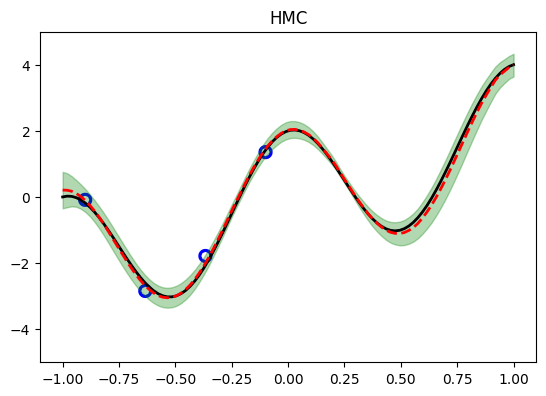

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x_train, y_train, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test, y_test, color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test, mu, color="red", linestyle="--", linewidth=2, label="mean")
ax.fill_between(x_test.flatten(), (mu+2*std), (mu-2*std), alpha=0.3, color="green", label="2 std")
# ax.legend(loc=0)
ax.set_ylim([-5, 5])
ax.set_box_aspect(2/3)
ax.set_title("HMC")
# fig.savefig("case_2_2_hmc.png")

In [11]:
sio.savemat(
    "./plot/case_1_hmc.mat",
    {
        "x_train": x_train,
        "u_train": y_train,
        "x_test": x_test,
        "y_test": y_test,
        "mu": mu, "std": std,
    }
)

#### Figure 2

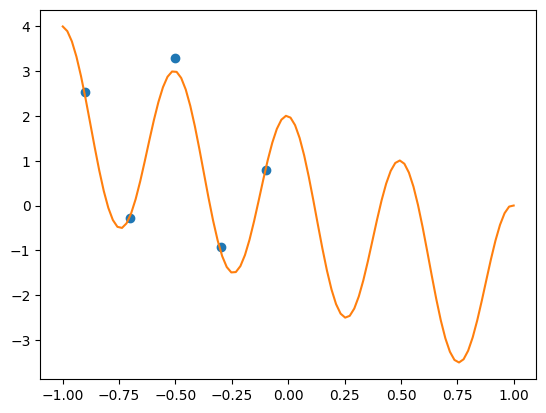

In [12]:
np.random.seed(6666) # for case 2
x_test = np.linspace(-1, 1, 100).reshape([-1, 1])

# case 2
x_train = np.linspace(-0.9, -0.1, 5).reshape([-1, 1])
A = 2
w = 4 * np.pi
k = -1

noise = 0.2

y_train = A * np.cos(w * x_train) + 2 * k * x_train
y_train = y_train + noise * np.random.normal(size=y_train.shape)
y_test = A * np.cos(w * x_test) + 2 * k * x_test

plt.plot(x_train, y_train, 'o')
plt.plot(x_test, y_test)

In [13]:
likelihood = neuq.likelihoods.Normal(
    inputs=x_train,
    targets=y_train, 
    sigma=noise, 
    processes=[process],
)

model = neuq.models.Model(
    processes=[process], likelihoods=[likelihood],
)

Supporting backend tensorflow



In [14]:
method = neuq.inferences.HMC(
    num_samples=1000,
    num_burnin=1000,
    init_time_step=0.1,
    leapfrog_step=30,
    seed=6666,
)
model.compile(method)

Compiling a MCMC method



In [15]:
t0 = time.time()
samples, results = model.run()
t1 = time.time()
print("Acceptance rate: %.3f \n"%(np.mean(results)))  # if HMC is used
print("Elapsed of HMC: ", t1 - t0)

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.742 

Elapsed of HMC:  62.294371128082275


In [16]:
heads = tf.transpose(samples[0])
y_pred = mhnn.call(
    tf.constant(x_test, tf.float32), heads 
)
y_pred = y_pred.numpy()

mu = np.mean(y_pred, axis=1)
std = np.std(y_pred, axis=1)
# std = np.sqrt(std**2 + noise**2)

Text(0.5, 1.0, 'HMC')

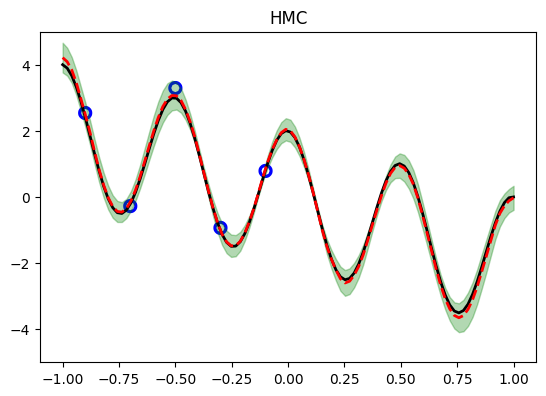

In [17]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x_train, y_train, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test, y_test, color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test, mu, color="red", linestyle="--", linewidth=2, label="mean")
ax.fill_between(x_test.flatten(), (mu+2*std), (mu-2*std), alpha=0.3, color="green", label="2 std")
# ax.legend(loc=0)
ax.set_ylim([-5, 5])
ax.set_box_aspect(2/3)
ax.set_title("HMC")
# fig.savefig("case_2_2_hmc.png")

In [20]:
sio.savemat(
    "./plot/case_2_hmc.mat",
    {
        "x_train": x_train,
        "u_train": y_train,
        "x_test": x_test,
        "y_test": y_test,
        "mu": mu, "std": std,
    }
)